In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Load data
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']

2024-06-26 14:27:51.119564: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-26 14:27:51.119590: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-26 14:27:51.119598: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-26 14:27:51.119618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-26 14:27:51.119630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#create mel spectrogram using tfio
import tensorflow_io as tfio

def create_mel_spectrogram(audio):
    """
    Create a mel spectrogram from an audio tensor.
    
    Args:
    audio (tf.Tensor): A 1D tensor containing the audio samples.
    
    Returns:
    tf.Tensor: A 2D tensor containing the mel spectrogram.
    """
    
    audio = tf.signal.stft(audio, frame_length=255, frame_step=128)
    audio = tf.abs(audio)
    audio = tfio.audio.melscale(audio, rate=16000, mels=128, fmin=0, fmax=8000)
    audio = tf.math.log(audio + 1e-6)
    audio = tf.transpose(audio)
    
    return audio

In [4]:
# Preprocess data
def preprocess_data(sample):
    """
    Preprocess a sample from the dataset.
    
    Args:
    sample (dict): A sample from the dataset.
    
    Returns:
    tuple: A tuple containing the mel spectrogram and the label.
    """
    audio = sample['audio']
    #convert to float32
    audio = tf.cast(audio, tf.float32)
    #make sure audio is 16000 samples
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    spectrogram = create_mel_spectrogram(audio)
    label = sample['label']
    #make label one-hot
    label = tf.one_hot(label, 10)
    
    return spectrogram, label

In [5]:
# # Test preprocess_data
# sample = train.take(1)
# sample = sample.map(preprocess_data)

In [6]:
# Create dataset
train_samples = train
train_data = train_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
print(train)

<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [7]:
print(train_data)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, None), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))>


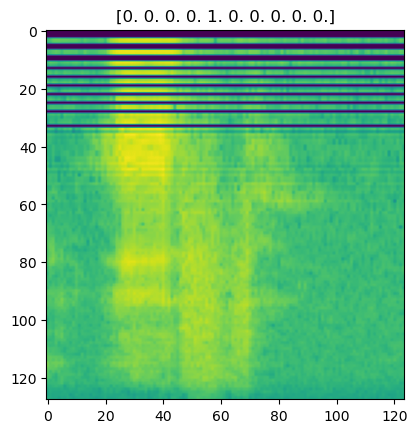

In [8]:
#visualize data
import matplotlib.pyplot as plt
for spectrogram, label in train_data:
    plt.figure()
    plt.imshow(spectrogram.numpy())
    plt.title(label.numpy())
    plt.show()
    break

In [9]:
#evaluate input shape
for spectrogram, label in train_data:
    if spectrogram.shape != (128, 124):
        print(spectrogram.shape)

2024-06-26 14:28:04.602486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
#batch
train_data = train_data.batch(32)

In [11]:
def build_model(num_classes):
  """
  Defines a CNN model for audio classification using mel spectrograms.

  Args:
      num_classes: The number of classes in your classification problem.

  Returns:
      A compiled TensorFlow Keras model.
  """
  inputs = layers.Input(shape=(128, 124))

  # Convolutional layers
  x = layers.Reshape((128, 124, 1))(inputs)
  x = layers.Conv2D(32, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D((2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D((2, 2))(x)

  # Flatten for fully-connected layers
  x = layers.Flatten()(x)

  # Fully-connected layers with dropout
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.5)(x)  # Adjust dropout rate as needed
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

  return model



In [18]:
# Get the number of classes from your data
num_classes = 10 # (get number of classes from your data)

# Build and train the model
model = build_model(num_classes)
model.summary()
model.fit(train_data, epochs=10)  # Adjust epochs as needed

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 124)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 128, 124, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 122, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 55680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,127,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,147,274 (27.26 MB)

 Trainable params: 7,147,274 (27.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 88s 32ms/step - accuracy: 0.1051 - loss: 10902576.0000
Epoch 2/10
  72/2673 ━━━━━━━━━━━━━━━━━━━━ 1:25 33ms/step - accuracy: 0.1026 - loss: 128553696.0000

KeyboardInterrupt: 

In [37]:
# Save the model
model.save("audio_classifier.keras")

In [38]:
# Load the model
model = tf.keras.models.load_model("audio_classifier.keras")

/opt/anaconda3/envs/kws/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
# Test the model
test = ds['test']
test_samples = test
test_data = test_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(32)
model.evaluate(test_data)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0832 - loss: 1363789.3750


[1331448.375, 0.07500000298023224]